### Imports

The following cell imports all necessary libraries/modules

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Creating dataloader

Transforming the data and creating an useful dataloader object to use for training.

In [2]:
class Sprites(Dataset):
    
    def __init__(self, images: str, transform=None):
        self.images = torch.from_numpy(np.load(images)) / 255
        self.transform = transform
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [43]:
BATCH_SIZE = 64

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
transforms = torchvision.transforms.Compose([
    
])

In [46]:
images = os.path.join("data", "sprites.npy")

sprites = Sprites(images=images, transform=transforms)

dataloader = DataLoader(
    dataset=sprites,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

### Looking at the data

In the following cells we take a look at the data

In [47]:
samples =  next(iter(dataloader))

In [48]:
samples[0]

tensor([[[0.9882, 0.9922, 0.9882],
         [0.9882, 0.9922, 0.9882],
         [0.9843, 0.9922, 0.9882],
         [0.9412, 0.9490, 0.9843],
         [0.2118, 0.3412, 0.9922],
         [0.2745, 0.3647, 0.9804],
         [0.1804, 0.3020, 0.9882],
         [0.8510, 0.8745, 0.9882],
         [0.9686, 0.9765, 0.9882],
         [0.4549, 0.5412, 0.9922],
         [0.2824, 0.3725, 0.9843],
         [0.1216, 0.2627, 0.9922],
         [0.8745, 0.8941, 0.9882],
         [0.9922, 0.9922, 0.9882],
         [0.9882, 0.9922, 0.9882],
         [0.9882, 0.9922, 0.9882]],

        [[0.9882, 0.9922, 0.9882],
         [0.9882, 0.9922, 0.9882],
         [0.9765, 0.9843, 0.9882],
         [0.6510, 0.7059, 0.9882],
         [0.1647, 0.3098, 0.9961],
         [0.8314, 0.7020, 0.9373],
         [0.4196, 0.4549, 0.9725],
         [0.1569, 0.2902, 0.9922],
         [0.9451, 0.9529, 0.9922],
         [0.1686, 0.3059, 0.9922],
         [0.8039, 0.6824, 0.9412],
         [0.2745, 0.3725, 0.9843],
         [0.2510, 

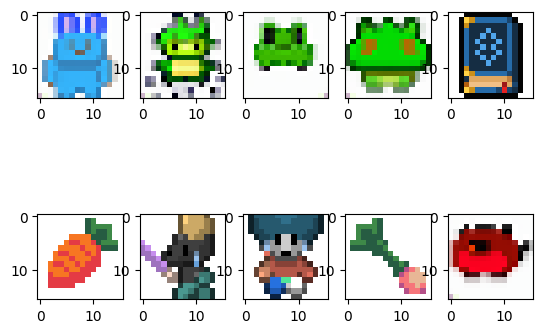

In [49]:
samples = samples[:10,:,:,:]

fig, axis = plt.subplots(2, 5)
axis = axis.flatten()

for i in range(10):
    axis[i].imshow(samples[i])

plt.show()

### Creating our networks

Creating the generator and discriminator network and it's necessary blocks and modules.

In [280]:
class PrintShape(nn.Module):
    """
    Neural network model used for debugging the shape.
    """
    
    def forward(self, x):
        print(x.shape)
        return x

In [281]:
class GeneratorBlock(nn.Module):
    
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.conv_trans2d = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        return self.activation(self.batch_norm(self.conv_trans2d(x)))

In [282]:
class Generator(nn.Module):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        n_G = 16
        self.net = nn.Sequential(
            GeneratorBlock(
                in_channels=100,
                out_channels=n_G * 4,
                kernel_size=4,
                stride=1,
                padding=0,
            ), # Output: BATCH_SIZE x 64 x 4 x 4
            GeneratorBlock(
                in_channels=n_G * 4,
                out_channels=n_G * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # Output: BATCH_SIZE x 32 x 8 x 8
            nn.ConvTranspose2d(
                in_channels=n_G * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1
            ), nn.Tanh()  # Output: BATCH_SIZE x 3 x 16 x 16
        )
        
    def forward(self, x):
        return self.net(x)

In [283]:
class DiscriminatorBlock(nn.Module):
    
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int,
            padding: int,
            alpha: float,
            **kwargs
    ):
        
        super().__init__(**kwargs)
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha)
        
    def forward(self, x):
        return self.activation(self.batch_norm(self.conv(x)))

In [284]:
class Discriminator(nn.Module):
    
    def __init__(self, alpha: float, **kwargs):
        super().__init__(**kwargs)
        
        self.net = nn.Sequential(
            DiscriminatorBlock(
                in_channels=3,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                alpha=alpha,
            ),  # Output: BATCH_SIZE x 16 x 8 x 8
            DiscriminatorBlock(
                in_channels=16,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                alpha=alpha,
            ),  # Output: BATCH_SIZE x 32 x 4 x 4
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [285]:
class GAN:
    
    def __init__(
            self, 
            alpha: float = 0.2,
            lr: float = 0.0002,
            betas: tuple[float, float] = (0.5, 0.999)
    ):
        
        self._gen = Generator().to(device)
        self._dis = Discriminator(alpha).to(device)
        
        self._gen_optim = torch.optim.Adam(
            params=self._gen.parameters(),
            lr=lr,
            betas=betas,
        )
        self._dis_optim = torch.optim.Adam(
            params=self._dis.parameters(),
            lr=lr,
            betas=betas,
        )
        
        self._loss = nn.BCELoss()
        
    def train(
            self,
            data: DataLoader,
            epochs: int = 10,
    ):
        
        for epoch in range(epochs):
            D_losses = []
            G_losses = []
            
            for real_X, _ in tqdm(data, f"Epoch {epoch +1}"):
                
                batch_size = real_X.shape
                
                # Updating discriminator
                Z = torch.normal(0, 1, size=(BATCH_SIZE, 100, 1, 1), device=device)
                
                fake_X = self._gen(Z).detach()
                fake_Y = self._dis(fake_X)
                
                real_Y = self._dis(real_X)
                
                ones = torch.ones_like(real_Y)
                zeros = torch.zeros_like(fake_Y)
                
                D_loss = (self._loss(real_Y, ones) + self._loss(fake_Y, zeros)) / 2
                D_losses.append(D_loss)
                
                self._dis_optim.zero_grad()
                D_loss.backward()
                self._dis_optim.step()
                
                # Updating generator
                Z = torch.normal(0, 1, size=(BATCH_SIZE, 100, 1, 1), device=device)
                
                fake_X = self._gen(Z)
                fake_Y = self._dis(fake_X)
                
                ones = torch.ones_like(fake_Y)
                
                G_loss = self._loss(fake_Y, ones)
                G_losses.append(G_loss)
                
                self._gen_optim.zero_grad()
                G_loss.backward()
                self._gen_optim.step()
            
            print(f"Average discriminator loss: {sum(D_losses) / len(D_losses):5.2f}")
            print(f"Average generator loss: {sum(G_losses) / len(G_losses):5.2f}")
                
    def generate_images(self, images: int) -> torch.Tensor:
        
        Z = torch.normal(0, 1, size=(images, 100, 1, 1), device=device)
        with torch.no_grad():
            images = self._gen(Z)
        return images

### Training the network

In [286]:
gan = GAN(
    alpha=0.2,
    lr=0.0002,
    betas=(0.5, 0.999)
)

In [287]:
gan.train(
    data=dataloader,
    epochs=10
)

Epoch 1: 100%|██████████| 1397/1397 [01:35<00:00, 14.59it/s]


Average discriminator loss:  0.64
Average generator loss:  0.77


Epoch 2: 100%|██████████| 1397/1397 [01:21<00:00, 17.15it/s]


Average discriminator loss:  0.46
Average generator loss:  1.09


Epoch 3: 100%|██████████| 1397/1397 [01:22<00:00, 16.89it/s]


Average discriminator loss:  0.35
Average generator loss:  1.42


Epoch 4: 100%|██████████| 1397/1397 [01:23<00:00, 16.66it/s]


Average discriminator loss:  0.33
Average generator loss:  1.54


Epoch 5: 100%|██████████| 1397/1397 [01:26<00:00, 16.18it/s]


Average discriminator loss:  0.33
Average generator loss:  1.59


Epoch 6: 100%|██████████| 1397/1397 [01:21<00:00, 17.05it/s]


Average discriminator loss:  0.33
Average generator loss:  1.63


Epoch 7: 100%|██████████| 1397/1397 [01:21<00:00, 17.10it/s]


Average discriminator loss:  0.32
Average generator loss:  1.67


Epoch 8: 100%|██████████| 1397/1397 [01:22<00:00, 17.01it/s]


Average discriminator loss:  0.33
Average generator loss:  1.70


Epoch 9: 100%|██████████| 1397/1397 [01:30<00:00, 15.37it/s]


Average discriminator loss:  0.33
Average generator loss:  1.71


Epoch 10: 100%|██████████| 1397/1397 [01:27<00:00, 15.93it/s]


Average discriminator loss:  0.34
Average generator loss:  1.71


### Inspecting results
Checking if our model did pookie

In [291]:
Z = torch.normal(0, 1, size=(10, 100, 1, 1), device=device)

with torch.no_grad():
    images = gan._gen(Z)
    labels = gan._dis(images)
    
images = images.permute(0, 2, 3, 1)/2+0.5

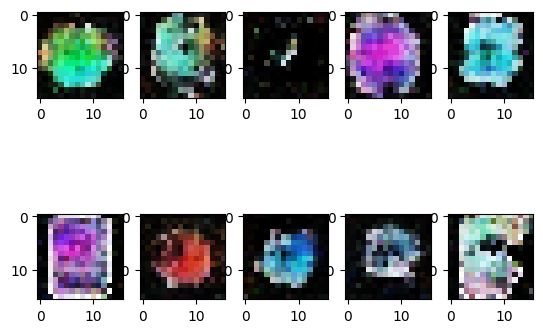

In [292]:
fig, axis = plt.subplots(2, 5)
axis = axis.flatten()

for i in range(10):
    axis[i].imshow(images[i], cmap='grey')

plt.show()

In [293]:
print(labels)

tensor([[[[0.3285]]],


        [[[0.1559]]],


        [[[0.2670]]],


        [[[0.0995]]],


        [[[0.6930]]],


        [[[0.1690]]],


        [[[0.3674]]],


        [[[0.1836]]],


        [[[0.1582]]],


        [[[0.2125]]]])
